In [8]:
from __future__ import division
from __future__ import print_function
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn import cross_validation
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize

import re
from HTMLParser import HTMLParser
import datetime
import cPickle as pickle
pd.options.mode.chained_assignment = None  # default='warn'

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import seaborn as sns

In [2]:
all_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withindgroup/all2.txt'
tech_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withindgroup/tech_all2.txt'

df1 = pd.read_csv(all_file, sep="|")
df2 = pd.read_csv(tech_file, sep="|")

In [44]:
df = df2.copy()

In [45]:
df.rename(columns={'gender':'gender1'}, inplace=True)
df.rename(columns={'gender_forced':'gender'}, inplace=True)

In [46]:
df['first_name'] = df['first_name'].apply(lambda x:'andrew' if x=='anew' else x)
df.loc[df.first_name.isin(['andrew']), 'gender'] = 'male'

In [47]:
df.gender.value_counts()

male      3528
female    1480
Name: gender, dtype: int64

# Modeling - Original Data

In [48]:
# Functions
def missing(df):
    if df.summary == 'missing' or df.num_tokens == 0:
        return 1
    else:
        return 0    

    
def lenx(mystr):
    return len(mystr.split())


def avgchrs(mytokens):
    tw = len(mytokens)    
    num_chars = 0
    for word in mytokens:
        num_chars += len(word)        
    return num_chars/tw


def remove_digits(mystr):
    '''
    INPUT: list of tokens 
    OUTPUT: list of tokens with digits removed
    '''
    return [word for word in mystr if not word.isdigit()]


stemmer = SnowballStemmer("english")
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def tokenize(text):
    tokens = word_tokenize(text)
    row = remove_digits(tokens)
    stems = stem_tokens(row, stemmer)
    return stems


def tokenize_no_stem(text):
    tokens = word_tokenize(text)
    row = remove_digits(tokens)
    stems = stem_tokens(row, stemmer)
    return tokens 


In [49]:
def preprocess_df(df):
    # Feature Engineering before running the prediction code
    df['class'] = np.ones(len(df))
    df['class'] = df['gender'].apply(lambda x: 0 if x == 'female' else 1)

    df['summ_tokens'] = df['summary'].apply(lambda x: nltk.word_tokenize(str(x)))
    df['num_tokens'] = df['summ_tokens'].apply(lambda x: len(x))

    # Add feature for missing summary
    df['summ_missing'] = df.apply(missing, axis = 1)

    # Only include rows with summaries
    df = df[df['summ_missing'] == 0]

    # Some Nan rows refuse to go without this
    df = df[pd.notnull(df['summary'])]

    print ("Length of DF after removing rows with missing Summaries:\n")
    print (len(df))

    df['avg_len'] = df['summ_tokens'].apply(lambda x: avgchrs(x))

    # lexical diversity = number of unique tokens / total number of tokens
    df['lex_diversity'] = df['summ_tokens'].apply(lambda x: len(set(x))/len(x))
    
    return df

In [ ]:
def rf_predict(df):
# Train-test split

    X_train, X_test, y_train, y_test = train_test_split(df['summary'], df['class'], test_size=0.3, random_state=0)
    vectorizer = CountVectorizer(analyzer = 'word', tokenizer = tokenize, ngram_range=(1,4), stop_words = stopwords, max_df = 0.7, min_df = 5, max_features = 5000)
    train_fit = vectorizer.fit_transform(X_train)
    train_fit = train_fit.toarray()
    feature_names = vectorizer.get_feature_names()

    print ("Training the random forest...")

    # Initialize a Random Forest classifier with 100 trees
    forest = RandomForestClassifier(n_estimators = 100) 

    # Fit the forest to the training set, using the bag of words as 
    # features and the sentiment labels as the response variable
    #
    # This may take a few minutes to run
    forest = forest.fit(train_fit, y_train)

    # Testing

    # Get a bag of words for the test set, and convert to a numpy array
    #test_data_features = vectorizer.transform(X_test)
    test_features = vectorizer.transform(X_test)
    test_features = test_features.toarray()

    # Use the random forest to make sentiment label predictions
    yhat = forest.predict(test_features)
    probX = forest.predict_proba(test_features)

    print ("Precision Score: {0}".format(precision_score(y_test, yhat)))
    print ("Recall Score: {0}".format(recall_score(y_test, yhat)))
    print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat)))
    print ("Model Score:{0}".format(forest.score(test_features, y_test)))
    
    fpr, tpr, thresholds = roc_curve(y_test, probX[:,1])    
    
    # Most important features
    num = 50
    imp = forest.feature_importances_
    feature_names = np.array(feature_names)
    features = feature_names[np.argsort(imp)[-num:]]
    weights = imp[np.argsort(imp)[-num:]]
    feats_with_vals = zip(features, weights)
    print ("Top 50 Features\n")
    for x in feats_with_vals:
        print (x)

        
    ## Naive Bayes Classifier
    nb_model = MultinomialNB()
    fitted_data = nb_model.fit(train_fit, y_train)
    yhat_nb = nb_model.predict(test_features)
    prob_nb = nb_model.predict_proba(test_features)
    
    print (nb_model)
    print ("Precision Score: {0}".format(precision_score(y_test, yhat_nb)))
    print ("Recall Score: {0}".format(recall_score(y_test, yhat_nb)))
    print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat_nb)))
    print ("Model Score:{0}".format(nb_model.score(test_features, y_test)))

    fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, prob_nb[:,1])
    
    ## Logistic Regression
    lr_model = LogisticRegression()
    fitted_data = lr_model.fit(train_fit, y_train)
    yhat_lr = lr_model.predict(test_features)
    prob_lr = lr_model.predict_proba(test_features)
    
    print (lr_model)
    print ("Precision Score: {0}".format(precision_score(y_test, yhat_lr)))
    print ("Recall Score: {0}".format(recall_score(y_test, yhat_lr)))
    print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat_lr)))
    print ("Model Score:{0}".format(lr_model.score(test_features, y_test)))

    fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, prob_lr[:,1])
        
    
    # ROC Curve
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    plt.plot(np.array(range(101))/100, np.array(range(101))/100, '--', color='black')
    plt.plot(fpr, tpr, label='rf-tfidf')
    plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
    plt.plot(fpr_lr, tpr_lr, label='Logistic')
    plt.ylabel("True Positive Rate ")
    plt.xlabel("False Positive Rate")
    plt.title("ROC plot")
    plt.legend(loc='lower right')

    plt.grid()
    plt.show()

In [ ]:
# Model 1
rf_predict(df)

In [ ]:
dftech1 = preprocess_df(dftech1)
rf_predict(dftech1)

In [ ]:
dfh = preprocess_df(dfh)
rf_predict(dfh)

In [ ]:
dfht = preprocess_df(dfht)
rf_predict(dfht)

In [ ]:
df_all2 = preprocess_df(df_all2)
rf_predict(df_all2)

In [ ]:
dftech_all = preprocess_df(dftech_all)
rf_predict(dftech_all)

In [ ]:
# with 3 grams

df_all2 = preprocess_df(df_all2)
rf_predict(df_all2)

In [ ]:
# with 3 grams and Adding Naive Bayes and Logistic Regression

df_all2 = preprocess_df(df_all2)
rf_predict(df_all2)

In [ ]:
dftech_all = preprocess_df(dftech_all)
rf_predict(dftech_all)

In [50]:
## Printing out the Random Forest Tree

X_train, X_test, y_train, y_test = train_test_split(df['summary'], df['class'], test_size=0.3, random_state=0)
vectorizer = CountVectorizer(analyzer = 'word', tokenizer = tokenize, ngram_range=(1,3), stop_words = stopwords, max_df = 0.7, min_df = 5, max_features = 5000)
train_fit = vectorizer.fit_transform(X_train)
train_fit = train_fit.toarray()
feature_names = vectorizer.get_feature_names()

print ("Training the random forest...")

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit(train_fit, y_train)

# Testing

# Get a bag of words for the test set, and convert to a numpy array
#test_data_features = vectorizer.transform(X_test)
test_features = vectorizer.transform(X_test)
test_features = test_features.toarray()

# Use the random forest to make sentiment label predictions
yhat = forest.predict(test_features)
probX = forest.predict_proba(test_features)

print ("Precision Score: {0}".format(precision_score(y_test, yhat)))
print ("Recall Score: {0}".format(recall_score(y_test, yhat)))
print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat)))
print ("Model Score:{0}".format(forest.score(test_features, y_test)))

fpr, tpr, thresholds = roc_curve(y_test, probX[:,1])    

# Most important features
num = 10
imp = forest.feature_importances_
feature_names = np.array(feature_names)
features = feature_names[np.argsort(imp)[-num:]]
weights = imp[np.argsort(imp)[-num:]]
feats_with_vals = zip(features, weights)
print ("Top 10 Features\n")
for x in feats_with_vals:
    print (x)


Training the random forest...
Precision Score: 0.740043446778
Recall Score: 0.953358208955
AUC Score: 0.560205786612
Model Score:0.727877578177
Top 10 Features

(u'user', 0.0025713692812399614)
(u'busi', 0.0028274914607165735)
(u'communic', 0.0030188437475448492)
(u'experi', 0.0030987841722823232)
(u'design', 0.0032707000584907479)
(u'engin', 0.0035334555548160568)
(u'technolog', 0.0035425399410076884)
(u'softwar', 0.0036792979690257964)
(u'manag', 0.0037989100132529846)
(u'develop', 0.0059760821554214368)


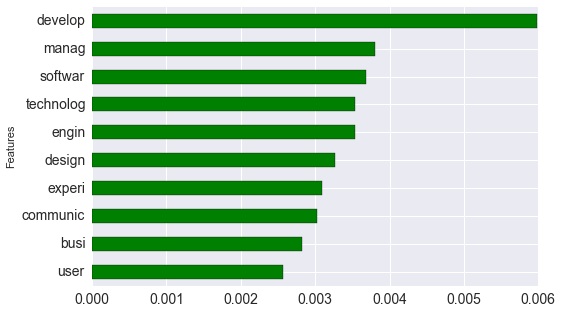

In [67]:
# Plotting the Top 10 Features for Random Forest

data = {'Features':features,
        'Weights':weights}

featdf = pd.DataFrame(data, columns = ['Features', 'Weights'])

featdf.plot(kind='barh', x=featdf['Features'], fontsize=14, figsize=(8, 5), legend=False, color='g')


# df = pd.DataFrame({'score':np.random.randn(6),
#                    'person':[x*3 for x in list('ABCDEF')]})

# ax = plt.subplot(111)
# df.score.plot(ax=ax, kind='barh', color=list('rgbkym'), title='ranking')
# ax.axis('off')
# for i, x in enumerate(df.person):
#     ax.text(0, i + .5, x, ha='right', fontsize='large')



In [42]:
features

array([u'manag', u'busi', u'develop', u'educ', u'communic', u'comput',
       u'softwar', u'technolog', u'women', u'engin'], 
      dtype='<U29')

In [17]:
y_test[y_test == 0]

22440    0
12989    0
18919    0
19567    0
24479    0
1734     0
6256     0
5753     0
2794     0
11741    0
16396    0
16162    0
21897    0
4044     0
9737     0
397      0
2084     0
10646    0
20120    0
12868    0
1730     0
11540    0
4658     0
26198    0
18876    0
807      0
24111    0
16640    0
2431     0
3695     0
        ..
24701    0
18765    0
7148     0
10659    0
18173    0
21902    0
7938     0
15145    0
1157     0
6017     0
6212     0
629      0
8788     0
23349    0
1419     0
1168     0
2248     0
684      0
25940    0
20985    0
11396    0
22083    0
23765    0
18063    0
11502    0
19635    0
6052     0
19390    0
3571     0
8747     0
Name: class, dtype: int64

In [52]:
fem_yhat = y_test[yhat==0]

In [54]:
fem_yhat

4580    1
530     1
3433    1
1412    1
4331    1
3660    1
1338    0
1850    0
2824    1
3501    0
2758    1
130     1
3394    1
1267    0
2308    0
4702    0
1161    1
2878    1
2876    1
2285    1
1042    0
4793    0
4720    0
29      0
2013    0
4275    0
347     1
4435    1
3245    0
4716    0
       ..
4291    1
4557    1
3131    0
3056    0
1596    1
4761    0
2951    0
917     0
1763    1
1385    0
3634    1
1277    1
3532    1
2134    0
1068    1
3154    0
3739    1
4984    1
206     0
4110    0
2315    1
3566    0
1830    1
3874    1
1969    0
3283    1
1273    1
1230    1
4726    0
2759    0
Name: class, dtype: int64

In [55]:
male_yhat = y_test[yhat==1]

In [56]:
male_yhat

405     1
4224    0
491     1
3118    0
1529    1
3375    1
463     0
138     1
1814    1
1741    1
3636    1
159     1
4321    0
3768    1
1087    1
2239    1
1965    0
2178    0
3416    1
2194    0
3600    1
402     1
533     1
495     0
4658    1
4810    1
4799    0
4246    1
2803    1
142     1
       ..
3180    1
687     1
1922    0
3238    1
4140    1
3207    1
2793    1
2585    0
1515    0
527     1
3294    0
2982    1
3270    1
794     1
2421    0
2329    0
3576    0
2373    0
1819    1
2984    0
3574    1
3705    1
2771    1
853     1
787     1
2618    1
4394    1
3158    1
1536    0
2346    1
Name: class, dtype: int64

In [68]:
df.ix[1042]

first_name                                                      april
full_name                                                  april ryan
html                ../../data/raw/2015-05-26-Washington/aprilryan...
industry                                               graphic design
location                                         greater seattle area
summary              april ryan has returned to the private sector...
title                                      Principal, Envision Design
counter                                                             1
source                                                        huskies
full_name_fields                                    ['april', 'ryan']
name_fields                                                         2
gender1                                                          male
gender_type                                                    female
gender                                                         female
name_counts         